Find similar light curves using kernel distances

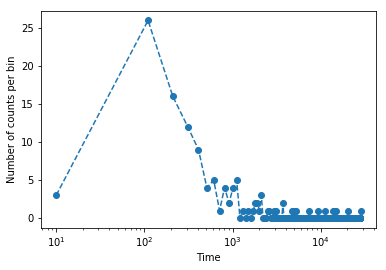

In [3]:
from astropy.io import fits

def get_light_curve(file_name, time_bin=100):
    with fits.open(file_name) as hdul:
        events = hdul[1].data
    time = np.sort(events['time'])
    #counts = events['counts']
    phased_time = (time - time[0])/time_bin
    x = np.arange(0, time[-1] - time[0], time_bin)
    y = np.bincount(np.trunc(phased_time).astype('int'))
    return time, x, y

time, x, y = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits')
plt.plot(x+10,  y, linestyle='--', marker='o')
plt.gca().set_xscale('log')
plt.ylabel('Number of counts per bin')
plt.xlabel('Time');

In [5]:
from os import listdir
from os.path import join

# Parameters
T = 5e+4
# Light curves
lc_path = "/home/phuijse/Data/XRAY/CSCVAR/"
file_list = [file for file in sorted(listdir(lc_path)) if file[-13:] == '_regevt3.fits']

## Schoenberg kernel

The Schoeberg kernel is a provably universal kernel
\begin{equation}
\kappa(x, y) = \phi \left( \|x -y \|^2 \right) = \phi \left ( \langle x, x\rangle + \langle y, y \rangle - 2 \langle x, y \rangle \right),
\end{equation}

where $\phi$ is a completely monotone function in $[0, \infty]$, e.g. $\phi(x) = \exp(-\alpha x)$.

The dot product can be replaced by
\begin{equation}
\kappa'(x, y) = \sum_{i,j} \exp \left ( -\frac{1}{\tau} | t_i^x - t_j^y| \right),
\end{equation}
which results from the $L_2$ dot product of two smoothed spike trains (sums of dirac deltas) represented as 
$$
f_x = x * h = \sum_i h(t - t_i), ~~ x(t) = \sum_{i} \delta(t - t_i),
$$
where $h(t) = \exp(-t/\tau), t>0$ is the finite-impulse response of a linear filter over time.

From: https://arxiv.org/pdf/1302.5964.pdf


In [21]:
%%time
# Comparing two point processes with kernels
# https://arxiv.org/pdf/1302.5964.pdf
# Eq. 5, nonlinear cross-intensity function
tau = 10.0
time_bin = 100
M = 20
D = np.zeros(shape=(M+1, M+1,))
K = np.zeros(shape=(M+1,))

for j in range(M+1):
    if j == M:
        t1, x1, y1 = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits', time_bin=time_bin)
    else:
        t1, x1, y1 = get_light_curve(join(lc_path, file_list[j]), time_bin=time_bin)
    #dt = x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis] - x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis].T
    dt = (t1[t1<T] - t1[0])[:, np.newaxis] - (t1[t1<T] - t1[0])[:, np.newaxis].T
    K[j] = np.sum(np.exp(-np.absolute(dt)/tau))/dt.shape[0]**2
    
for j in range(M+1):    
    if j == M:
        t1, x1, y1 = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits', time_bin=time_bin)
    else:
        t1, x1, y1 = get_light_curve(join(lc_path, file_list[j]), time_bin=time_bin)
    for i in range(j, M+1):
        if i == M:
            t2, x2, y2 = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits', time_bin=time_bin)
        else:
            t2, x2, y2 = get_light_curve(join(lc_path, file_list[i]), time_bin=time_bin)
        
        dt = (t1[t1<T+t1[0], np.newaxis] - t1[0]) - (t2[t2<T+t2[0], np.newaxis] - t2[0]).T
        #dt = x1[(x1<T) & (y1>0)][:, np.newaxis] - x2[(x2<T) & (y2>0)][:, np.newaxis].T
        #dt = x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis] - x2[(x2<T) & (y2>np.mean(y2))][:, np.newaxis].T
        #D[i] = K1 + K2 - 2*np.sum(np.exp(-0.5*dt**2/s**2))/(dt.shape[0]*dt.shape[1])
        D[i, j] = K[i] + K[j] - 2*np.sum(np.exp(-np.absolute(dt)/tau))/(dt.shape[0]*dt.shape[1])
        D[j, i] = D[i, j]
#plt.plot(x+10,  y, linestyle='--', marker='o')
#plt.gca().set_xscale('log')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


MemoryError: 

In [ ]:
s = 0.01
G = np.exp(-0.5*D/s**2)
pca = PCA(n_components=2)
D_red = pca.fit_transform(G)
plt.scatter(D_red[:, 0], D_red[:, 1])
for i in range(M+1):
    plt.annotate(str(i), (D_red[i, 0], D_red[i, 1]))

In [14]:
def kde_spike(t, s=1):
    #T = t[-1] - t[0]
    #new_t = np.arange(0.0, np.amin([T, t[-1] - t[0]]) , step=10.0)
    new_t = np.arange(2*s, t[-1] - t[0] - 2*s, step=10.0)
    smoothed = np.zeros(shape=(len(new_t),))
    for i in range(len(t)):
        smoothed += np.exp(-0.5*(new_t - t[i]+t[0])**2/s**2)
    return new_t, smoothed

In [17]:
%%time
# Paiva's thesis 4-4, generalized cross-correlation
lc_idx = 28
t1, x1, y1 = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits', time_bin=1)
t2, x2, y2 = get_light_curve(join(lc_path, file_list[lc_idx]), time_bin=1)

D = list()
overlap = 20
N = np.argmin((t2[:] - t2[-1] + 5e+3)**2)//overlap
for i in range(np.amin([N, 1000])):
    idx = np.argmin( (t2[overlap*i:] - t2[overlap*i] - 5e+3)**2) + overlap*i
    if idx >= len(t2):
        break
    t2_tmp = t2[overlap*i:idx] - t2[overlap*i]
    dt = t1[:, np.newaxis] - t1[0] - t2_tmp[:, np.newaxis].T
    D.append(np.sum(np.exp(-np.absolute(dt)/tau))/(dt.shape[0]*dt.shape[1]))
D = np.array(D)

CPU times: user 5.95 s, sys: 3.58 ms, total: 5.95 s
Wall time: 5.98 s


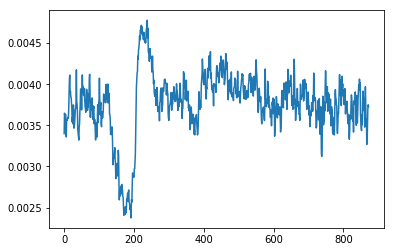

In [20]:
plt.plot(D)

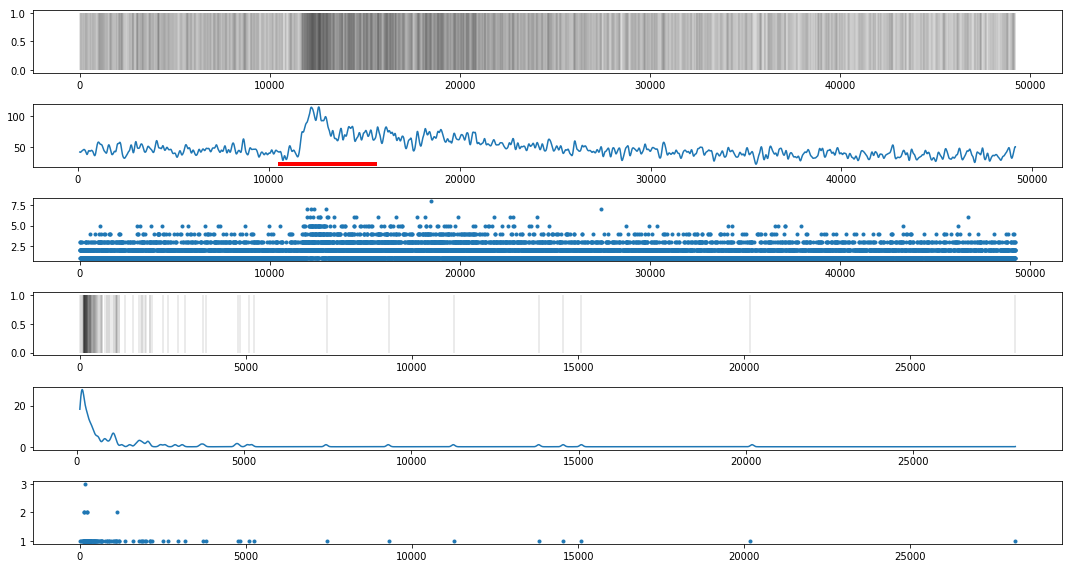

In [19]:
d = lc_idx
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(6, 1, 1)
t2, x2, y2 = get_light_curve(join(lc_path, file_list[d]), time_bin=1)
ax.vlines(t2[(t2<2*T+t2[0])] - t2[0], ymin=0.0, ymax=1.0, alpha=0.01)
ax = fig.add_subplot(6, 1, 2)
t_kde, x_kde = kde_spike(t2[t2<2*T+t2[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
plt.plot([t2[np.argmin(D)*overlap] - t2[0], t2[np.argmin(D)*overlap] - t2[0] + 5e+3], 
         [np.amin(x_kde), np.amin(x_kde)], 'r', linewidth=4)
ax = fig.add_subplot(6, 1, 3)
ax.plot(x2[(x2<2*T) &(y2>np.mean(y2))], y2[(x2<2*T) &(y2>np.mean(y2))], '.')

ax = fig.add_subplot(6, 1, 4)
t, x, y = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits', time_bin=1)
#t, x, y = get_light_curve(join(lc_path, file_list[d2]), time_bin=1)
ax.vlines(t[(t<T+t[0])] - t[0], ymin=0.0, ymax=1.0, alpha=0.1)
ax = fig.add_subplot(6, 1, 5)
t_kde, x_kde = kde_spike(t[t<T+t[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
ax = fig.add_subplot(6, 1, 6)
ax.plot(x[(x<T) & (y>np.mean(y))], y[(x<T) & (y>np.mean(y))], '.')
#ax.set_xscale('log')
plt.tight_layout()